<a href="https://colab.research.google.com/github/sameersundrani/ResourceAllocation211x/blob/main/mseCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imported Libraries & gDrive Mounting

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from google.colab import drive
import cvxpy as cp
import math
from numpy import linalg as LA

In [ ]:
drive.mount('/content/drive', force_remount=True)
FOLDERNAME = '/content/drive/MyDrive/MSE211x_Final_Project'


Mounted at /content/drive


In [ ]:
np.random.seed(15)
k = [50, 100, 200]
m = 10 # number of goods
n = 10000  # number of bidders
p = np.random.uniform(0, 1, m)

A = np.random.randint(2, size=(m, n))
b = np.ones(m)*1000

pi = np.matmul(np.transpose(A), p) + np.random.normal(0, math.sqrt(0.2), n)
X = np.zeros((n, len(k)))

rev = {}
accepted = {}
dual = {}


# Question 1


In [ ]:
# Offline solution
x_off = cp.Variable(n, nonneg=True)
constraints_off = [A @ x_off <= b, x_off <= 1]
prob_off = cp.Problem(cp.Maximize(pi.T @ x_off), constraints_off)
prob_off.solve()

y_off = constraints_off[0].dual_value
off_rev = prob_off.value
print(off_rev)
print(np.sum(x_off.value))

4503.271670222161
2224.666666285453


In [ ]:
for i in range(len(k)):
  x = cp.Variable(k[i], nonneg=True)
  constraints = [A[:,0:k[i]] @ x <= (k[i]/n)*b, x <= 1]
  prob = cp.Problem(cp.Maximize(pi[0:k[i]].T @ x), constraints)
  prob.solve()
  y = constraints[0].dual_value
  dual[i] = y
  # X[0:k[i], i] = x.value
  s = np.zeros(m)
  #s = np.matmul(A[:, 0:k[i]], x)
  for j in range(k[i]+1, n):
    if (s + A[:, j] <= b).all() and (pi[j] > np.dot(A[:, j], y)):
      X[j, i] = 1
      s = s + (A[:, j] * X[j, i])
    else:
      X[j, i] = 0
  rev[k[i]] = np.dot(pi, X[:, i])
  accepted[k[i]] = sum(X[:, i])
  
print(rev)
print(accepted)

{50: 3328.150054740353, 100: 3817.176986240099, 200: 3988.388114348342}
{50: 1735.0, 100: 1935.0, 200: 1965.0}


In [ ]:
total50 = np.multiply(pi, X[:, 0])
total100 = np.multiply(pi, X[:, 1])
total200 = np.multiply(pi, X[:, 2])



In [ ]:
for val in rev.values():
  print(val/off_rev)


0.7390515825966512
0.8476452823135551
0.8856645582191983


In [ ]:
# Small k allows for a shorter wait time before accepting bids. Since we need to wait after k bidders to get the shadow price, a smaller k will allow us to make decisions faster.
# Larger k leads to higher revenue and closer to the offline algorithm. 

print(LA.norm(p - dual[0]))
print(LA.norm(p - dual[1]))
print(LA.norm(p - dual[2]))




0.7708497347222916
0.3904725612050795
0.31976513379216426


# Question 2

In [ ]:
def solve_dual(k, pi, n, b, A):
    x = cp.Variable(k, nonneg=True)
    constraints = [A[:,0:k] @ x <= (k/n)*b, x <= 1]
    prob = cp.Problem(cp.Maximize(pi[0:k].T @ x), constraints)
    prob.solve()
    return constraints[0].dual_value

def compute_opt_diff(pi, X, n, k, OPT):
  return np.dot(pi[0:k], X[0:k]) - (k/n)*OPT

In [ ]:
X = np.zeros(n)
kk = [50, 100, 200, 400, 800]
duals = {}
y = np.zeros(m)
opt_diff_SLPM = np.zeros(n)
duals[i] = y
s = np.zeros(m)
for i in range(50, n):
  if i in kk:
    y = solve_dual(i, pi, n, b, A)
    duals[i] = y
  if (s + A[:, i] <= b).all() and (pi[i] > np.dot(A[:, i], y)):
      X[i] = 1
      s = s + (A[:, i] * X[i])
  else:
      X[i] = 0
  opt_diff_SLPM[i] = compute_opt_diff(pi, X, n, i, OPT=4503.271670222161)
print(np.dot(pi, X))
print(np.sum(X))


4132.061770675931
2109.0


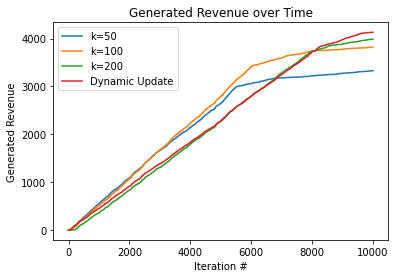

In [ ]:
x = np.array(range(0, 10000))
totaldy = np.multiply(X, pi)

def calc_rev(rev):
  y = np.zeros(10000)
  y[0] = rev[0]
  for i in range(1, y.size):
    y[i] = y[i-1] + rev[i]  
  return y

y50 = calc_rev(total50)
y100 = calc_rev(total100)
y200 = calc_rev(total200)
ydy = calc_rev(totaldy)


plt.plot(x, y50, label = "k=50")
plt.plot(x, y100, label = "k=100")
plt.plot(x, y200, label = "k=200")
plt.plot(x, ydy, label = "Dynamic Update")


plt.xlabel("Iteration #")
plt.ylabel("Generated Revenue")
plt.title("Generated Revenue over Time")
plt.legend()

# Question 3: Action-history-dependent Learning Algorithm

In [ ]:
def solve_dual_AHDL(k, pi, n, b, A):
    x = cp.Variable(k, nonneg=True)
    constraints = [A[:,0:k] @ x <= (k/(n-k))*b, x <= 1] #updated for ADHL
    prob = cp.Problem(cp.Maximize(pi[0:k].T @ x), constraints)
    prob.solve()
    return constraints[0].dual_value

def AHDL(pi, A, b, p, OPT):
  m = A.shape[0]
  n = A.shape[1]
  opt_diff = np.zeros(n) #measurement of performance over time (note: opt_diff[0] will always be zero since we don't start the update until k = 2)
  X = np.zeros(n) #decision vector 
  y_prev = np.zeros(m) #initial dual price = 0 (see ref[6] for justification here)
  for i in range(1, n):
    if (b - A[:, i] >= np.zeros(m)).all() and (pi[i] > np.dot(A[:, i], y_prev)): #we have resources for this bid and are going to make money
      X[i] = 1
      b = b - A[:, i] #update b for new resources
    opt_diff[i] = compute_opt_diff(pi, X, n, i, OPT)
    y_prev = solve_dual_AHDL(i, pi, n, b, A) #get prev dual solution for next iteration

  return X, opt_diff

In [ ]:
OPT = 4503.271670222161 #computed above
inventory = b.copy()

X_ahdl, opt_diff = AHDL(pi=pi, A=A, b=inventory, p=p, OPT=4503.271670222161)

In [ ]:
print("Num Accepted Bids = ", np.sum(X_ahdl))
print("Total Revenue = ", np.dot(pi, X_ahdl))

Num Accepted Bids =  2227.0
Total Revenue =  4476.241301729757


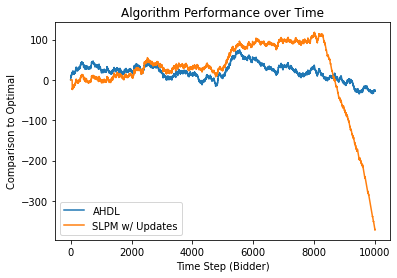

In [ ]:
plt.plot(range(len(X)), opt_diff, label='AHDL')
plt.plot(range(len(X)), opt_diff_SLPM, label='SLPM w/ Updates')
plt.title('Algorithm Performance over Time')
plt.xlabel('Time Step (Bidder)')
plt.ylabel('Comparison to Optimal')
plt.legend()

# Question 4

(Noah rough notes)

The dual of (1) is given by
$$minimize~~\sum_{i=1}^m b_iy_i + \sum_{j=1}^n p_j$$
$$s.t.~~ \sum_{i=1}^m a_{ij}y_i + p_j \geq \pi_j, ~\forall ~j=1,...,n$$
$$y_i, p_j \geq 0 ~ \forall i=1,...,m ~j=1,...,n$$
Where decision variables are
$$\textbf{y} = (P_1,...,p_m)^T~~and~~\textbf{p} = (y_1,...,y_n)^T$$
Plugging the constraints into the objective function of the dual we get 
$$min~~\sum_{i=1}^m b_iy_i + \sum_{j=1}^n (\pi_j - \sum_{i=1}^m a_{ij}y_i)^+$$
$$s.t.~~~ y_i \geq 0, ~\forall ~i=1,...,m$$
Let $\textbf{d} = \textbf{b}/n$. Dividing through by n we get
$$min~~\sum_{i=1}^m d_iy_i + \frac{1}{n}\sum_{j=1}^n (\pi_j - \sum_{i=1}^m a_{ij}y_i)^+$$
$$s.t.~~~ y_i \geq 0, ~\forall ~i=1,...,m$$
Define $f_n(y)$ as the objective function of the above problem and define $f(y)$ as the objective function of (3). As this dual program is an n-sample approximation of the program (3)
$$\implies \mathbb{E}f_n(y) = f(y)$$

# Question 5

In [ ]:
def get_loss(y, pi, A, b):
  return np.dot(b/n, y) + max((pi.mean() - np.dot(A.mean(axis=1), y)), 0)

def get_gradient(y, pi, A, b):
  n = 10000
  d = b / n
  ind = np.zeros(A.shape[0])
  if (pi > (A.T @ y)):
    ind = ind + np.ones(A.shape[0])
  aInd = ind*A
  grad_approx = d - aInd
  return grad_approx

def sample_batch(y, pi, A, batch_size=1):
  idx = np.random.choice(A.shape[1], size=batch_size, replace=False)
  return pi[idx], A[:, idx]

def sgd(pi, A, b, p, epochs=10000, eps = 0.0000001):
  loss = []
  grad = 0
  y_prev = np.zeros(A.shape[0])
  y = np.zeros(A.shape[0])
  loss_prev = 0 #set arbitrarily
  for k in range(epochs):
    
    # set lr
    lr = 1 / np.sqrt(k+1)

    # sample batch (size = 1)
    pi_k = pi[k]
    A_k = A[:, k]

    # get grad from random batch
    grad = get_gradient(y_prev, pi_k, A_k, b)

    # update X with this grad
    y = y_prev - grad*lr
    
    # exit if we converge early
    loss_k = get_loss(y, pi, A, b)
    diff = np.abs(loss_k - loss_prev)
    loss.append(loss_k)

    y_prev = y
    loss_prev = loss_k

    # print to debug
    if (k%1000 == 0):
      print(f'Current Loss = %f' %(loss_k))
  
  return y, loss


def get_x(y, pi, A, b):
  n = A.shape[1]
  X = np.zeros(n)
  for i in range(n):
    if (b - A[:, i] >= np.zeros(m)).all() and (pi[i] > np.dot(A[:, i], y)): #we have resources for this bid and are going to make money
      X[i] = 1
      b = b - A[:, i] #update b for new resources
  opt_rev = np.dot(pi, X)
  return X, opt_rev

In [ ]:
p_sgd, loss_list_sgd = sgd(pi, A, b, p)

Current Loss = 1.605008
Current Loss = 0.385027
Current Loss = 0.383358
Current Loss = 0.392355
Current Loss = 0.368302
Current Loss = 0.387888
Current Loss = 0.395591
Current Loss = 0.395280
Current Loss = 0.399854
Current Loss = 0.382656


Text(0, 0.5, 'Loss')

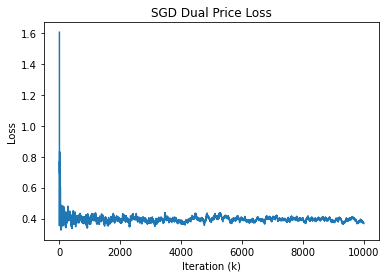

In [ ]:
plt.plot(loss_list_sgd)
plt.title('SGD Dual Price Loss')
plt.xlabel('Iteration (k)')
plt.ylabel('Loss')

In [ ]:
print(f'Final Norm Difference (SGD) = %f' %(np.linalg.norm(p_sgd - p)))

Final Norm Difference (SGD) = 0.210521


In [ ]:
X, opt_rev_sgd = get_x(p_sgd, pi, A, b)

In [ ]:
print(f'Accepted Number of Bids (SGD) = %f' %(np.sum(X)))
print(f'Total Revenue (SGD) = %f' %(opt_rev_sgd))

Accepted Number of Bids (SGD) = 2108.000000
Total Revenue (SGD) = 4180.687178
